# <center> Mecánica de los Fluidos computacional <center>

#  <center> Caso de aplicación <center>
#  <center>  Tobera 1D con SIMPLE y Rhie Chow <center>

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

### Ejemplo de Aplicación

Se aplicará el algoritmo SIMPLE a un caso de flujo unidimensional con cambio de área: una tobera convergente de 2 metros de longitud que descarga un gas de densidad $\rho=1 \frac{kg}{m^3}$. 

Se conoce la ley de variación del área y las presiones en la entrada y salida de la misma son conocidas: 
- en la salida la presión es ambiente
- en la entrada se conoce que **la presión de estancamiento** es de 10 Pa (manométrica)


![title](figs/tobera_geo.png)

Para resolver este caso usamos una discretización con cuatro celdas (siendo $nx=4$ el número de celdas) como se muestra en la Fig. El algoritmo se ejecuta  un número de iteraciones $ni=5$

![title](figs/Nozzle_RC/estr_datos_SIMPLE_nozzle_rhie_chow.png)

Se almacenan las presiones y velocidades en los centroides de las celdas, y los valores en las caras se obtienen por interpolación. Como los valores de la presión en la entrada y salida de la tobera están definidos por las condiciones de contorno,  se añaden dos datos más de presión. Representan el valor de la presión en las caras de entrada y salida.

#### Estructura de datos
De la misma manera ocurre con las demás variables escalares  y vectoriales: $\rho$, $\mu$, etc. se definen en los centroides de las celdas. Luego se almacenan en arreglos unidimensionales con dimiensión $nx$

Por otro lado, a las variables del problema (la presión y la velocidad) se las almacena en un arreglo bidimensional de dimensión $[ nx, ni+1]$, donde en cada columna se almacenan los valores obtenidos en cada celda para la $j-esima$ iteración  


#### Condición inicial

Proponemos una distribución de presiones  inicial que varía linealmente a lo largo de la tobera 
$$ p(x) = p_0 +\frac{p_L-p_0}{L}x $$
La distribución de velocidades se obtiene proponiendo un caudal másico constante de $\dot{m}=1 kg/s$
$$ u_j =\frac{\dot m}{\rho_j A_j}$$

Se asume además que el flujo es invíscido. 



In [5]:
import numpy
from matplotlib import pyplot
"""
solución de ec. de navier stokes 1D por el esquema simple
usando la interp de rhie chow para mallas collocated
"""
ni=1 #número de iteraciones

L=2 #longitud
nx=4#número de nodos en x
dx=L/nx

# Factores de subrelajacion para presion y velocidad

alfap=0.2; alfav=0.8;


p_inf=10; #presión de estancamiento en extr izq
pE=0; #presión manométrica en la salida

"""
vectores de parámetros
"""
ρ=numpy.ones(nx)#ditribucion de densidad en los centros
μ=numpy.ones(nx)*0 #viscosidad  en los centros
A=numpy.ones(nx+1) #distribución de areas en las interfaces (caras)
d= numpy.ones(nx) #coefs para la cons de masa
Res_vel=numpy.zeros(ni+1)
E_vel=numpy.zeros(ni+1)
E_pres=numpy.zeros(ni+1)
"""
discretización espacial
"""
A0=0.5;  AL=0.1;

# coords de centros de celdas
x_cel = numpy.linspace(dx/2, L-dx/2, nx) 

#coords donde se valúa la presión

x_pres=numpy.append(0, x_cel);
x_pres=numpy.append( x_pres, L);


#coords de centros de caras  (interfaces)
x_face=numpy.linspace( 0, L, nx+1)

A[:]=A0+(AL-A0)/L*x_face[:]

La condición inicial resulta entonces

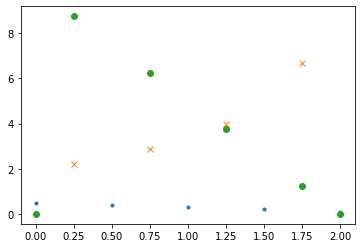

In [6]:
"""
    Guess inicial para presión y velocidad
"""
p=numpy.zeros((nx+2,ni+1)) # campo de presiones
u=numpy.zeros((nx,ni+1)) # campo de velocidades
caud_inic=1 #caudal másico inicial estimado
u[0:nx, 0]= caud_inic / (ρ[0:nx]*(A[0:nx]+A[1:nx+1])/2) # condicion inicial de versteeg 
#asumiendo caudal másico unitatio
p[1:nx+1,0]=p_inf+(pE-p_inf)/L*x_cel #interpolación lineal para p inicial
#presión en la salida derecha (cond de contorno der)
p[nx+1,: ]=pE 



pyplot.figure(0)
pyplot.plot(x_face, A,  lw=0.0 , marker='.') 
pyplot.plot(x_cel, u[:,0],  lw=0.0 , marker='x')                    
pyplot.plot(x_pres, p[:,0],  lw=0.0 , marker='o')
#pyplot.plot(x_face, μ,  lw=0.0 , marker='+')
#pyplot.xlabel("x")
#pyplot.ylabel("φ")
#pyplot.gca().legend(('U','P'))#('area','visc'))
#pyplot.grid(b=None, which='major', axis='both')

### Flujos

#### Difusivos
En el presente problema los flujos difusivos son todos nulos, ya que la viscosidad es cero. Sin embargo, se evalúan en cada celda mediante

$$F_D=\mu_f A_f \frac{d u}{dx}_f=\left( \frac{\mu_i +\mu_{i-1}}{2}\right) A_f \frac{u_i-u_{i-1}}{\Delta X} $$

Directamente se define la variable 
$$D=\left( \frac{\mu_i +\mu_{i-1}}{2}\right) A_f \frac{1}{\Delta X}$$
 que resulta más práctica para ensamblar la matriz de coeficientes
 
 #### Convectivos
 
 Los flujos convectivos se evalúan de manera convencional, evaluando los flujos analíticos en los centroides de las celdas y promediándolos en las caras
 
$$  F = \left( \frac{\rho_{i-1} u_{i-1}+\rho_i u_i}{2} \right) A_f$$
 


### Condiciones de contorno

##### Entrada izquierda

En la entrada izquierda tenemos establecida una presión de estancamiento, luego la presión estática en la cara $0$ será 

$$p[0]=p_\infty - \frac{\rho u(x=0)^2}{2}$$ 

donde $p[0]=p(x=0)$. Como no se conoce la velocidad en la cara $0$, se extrapola su valor mediante la conservación de la masa
$$u(x=0)=\frac{u[0] A_c [0]}{A[0]}$$

donde $u[0]$ y $ A_c [0]$ son la velocidad y el área en el centroide de la celda 0 respectivamente, y $ A[0]$ es el área de la cara 0

Para escribir la ec. de conservación de cantidad de movimiento es necesario expresar la presión en la cara 0 en función de los flujos y la velocidad $u[0]$.

La ec. de conservación de cantidad de movimiento considerando un esquema upwind resulta

$$ F_e u[0] - F_w u(x=0)= (p[0]-p(x=x_{f1}))A_c [1]$$

La presión en la cara 1 se obtiene promediando las presiones en los centros de las celdas 0 y 1, es decir $p[1]$ y $p[2]$ respectivamente

$$p(x=x_{f1})=\frac{p[1]+p[2]}{2}$$
y el flujo en la cara izquierda (oeste, W) se obtiene mediante conservación de masa

$$F_w= \rho(x=0) A[0] u(x=0) =\rho[0] A_c[0]u[0]= F_e$$

Reemplazando estos resultados en la Ec. de cantidad de movimiento y sacando factor común $u[0]$ se obtiene


$$ F_e u[0] - F_w \frac{u[0] A_c [0]}{A[0]} + \frac{\rho}{2}\left( \frac{ A_c [0]}{A[0]}\right)^2 u[0]^2= \left(p_\infty-\frac{p[1]+p[2]}{2}\right)A_c [1]$$

Para mayor estabilidad numérica se busca que el coeficiente de la matriz $M_u[0][0]$ tenga el mayor valor positivo posible. Por esta razón se pasa al miembro derecho al término $F_w \frac{u[0] A_c [0]}{A[0]}$  tomando el valor de $u[0]$ de la iteración anterior,  para aumentar la estabilidad numérica

#####  Salida Derecha

En el caso de la salida derecha se conoce que la presión estática es igual a la presión ambiente, luego para cada iteración debe cumplirse que 
$$ p[n+1]=0$$

Por otro lado, el flujo en la cara derecha ($A[n]$) se evalúa mediante conservación de la masa:


$$F_e[n]= \rho(x=L) A[n] u(x=L) =\rho[n] A_c[n]u[n]$$

In [ ]:
"""
bucle principal de iteraciones
"""

for k  in range(ni):
    """
    asignación de memoria para variables
    """
    print('iter ', k)
    M_vel=numpy.zeros((nx, nx)) # matriz de coefs de influencia para la velocidad u
    RHS_vel=numpy.zeros(nx)
    F_w=numpy.zeros(nx)
    F_e=numpy.zeros(nx)
    D_w=numpy.zeros(nx)
    D_e=numpy.zeros(nx)
    p_e=numpy.zeros(nx)
    p_ee=numpy.zeros(nx)
    p_w=numpy.zeros(nx)
    
    A_c=numpy.zeros(nx) #areas en centros de celdas
    
    M_p=numpy.zeros((nx, nx)) # matriz de coefs de influencia para la presion
    RHS_p=numpy.zeros(nx)
    """
    sistema de ecuaciones para la velocidad empleando el esquema upwind
    """
# convención de índices 
#se usa I para la velocidad, donde I=i+1/2

    for i in range(1, nx-1):
    #flujos convectivos en los centros de las celdas de velocidad
        I=i #se usa I para la velocidad
        A_c[i]=(A[i]+A[i+1])/2.0; 
        #F_ip3o2=(ρ[i+2]+ρ[i+1])/2.0 *u[I+2,k];
        #F_ip1o2=(ρ[i]+ρ[i+1])/2.0 *u[I+1,k];
        #F_im1o2=(ρ[i]+ρ[i-1])/2.0 *u[I,k];  
        #F_im3o2=(ρ[i-1]+ρ[i-2])/2.0 *u[I-1,k]; 
        
        #flujos en las interfaces en celdas de velocidad
        F_w [i] = (ρ[i-1] *u[i-1, k]+ ρ[i] *u[i, k])/2.0*A[i]
        F_e[i] =(ρ[i+1] *u[i+1, k]+ ρ[i] *u[i, k])/2.0*A[i+1]
        
        #print(" i= %d, F_w= %6f, F_e=%6f" % (i, F_w[i] , F_e[i]))
        #F_im1 =(F_im1o2+F_im3o2)/2.0*A[i-1]
        #flujos difusivos
    
        D_w[i]=μ[i-1]*A[i]/dx;     D_e[i]=μ[i]*A[i+1]/dx;
        
        #Esquema upwind generalizado (CIR)
        M_vel[i][i-1] = (-D_w[i]-max(F_w[i], 0));# coef a_i-1/2
        M_vel[i][i+1] = (-D_e[i]+min(F_e[i], 0)); # coef a_i+3/2
        M_vel[i][i]   =  D_w[i]+D_e[i]+max(F_w[i], 0)-min(F_e[i], 0)+(F_e[i]-F_w[i]);
        # M_vel[i][i]   =  D_i+D_ip1+min(F_i[i], 0)-max(F_ip1[i], 0)+(F_ip1[i]-F_i[i]);
        d[i]=A_c[i]/M_vel[i][i]
        #presiones en las caras de las celdas
        p_e[i]=(p[i+1, k]+p[i+2,k])/2
        p_w[i]=(p[i+1, k]+p[i,k])/2
        RHS_vel[i]=-(p_e[i]-p_w[i])*A_c[i]#/dx

    #valores en el contorno
    
    #se asume condición de far field en el extremo izquierdo
    A_c[0]=(A[0]+A[1])/2
    uA=u[0, k]*A_c[0]/A[0]
    #uA=u_star[0]*A_c[0]/A[0]
    pA=p_inf-1/2*ρ[0]*uA**2
    p[0, k]=pA
    D_w[0]=2*μ[0]*A[0]/dx;    
    F_w[0]=ρ[0]*uA*A[0];   

    # BC izquierda
    #u_3o2=(u[0, k]+u[1, k])/2  #u_3/2
    
    D_e[0]=μ[1]*A[1]/dx
    
    F_e[0]=(ρ[1] *u[1, k]+ ρ[0] *u[0, k])/2*A[1]

   # print(" i= %d, F_i= %6f, F_ip1=%6f" % (0, F_0 , F_1))
    M_vel[0][0] =-min(F_e[0], 0)+max(F_w[0],0)+D_e[0]+D_w[0]+(F_e[0]-F_w[0])+F_w[0]*(A_c[0]/A[0])**2/2
    M_vel[0][1]   =-D_e[0]- min(F_e[0],0)
    d[0]=A_c[0]/M_vel[0, 0]
    #revisar interp de presión en el contorno
    p_e[0]=(p[1, k]+p[2,k])/2
    #p_e[0]=(p[0, k]+p[1,k])/2
    RHS_vel[0] = (p_inf-p_e[0])*A_c[0]+F_w[0]*u[0, k]*A_c[0]/A[0]#/dx
    
    # BC derecha
    A_c[nx-1]=(A[nx]+A[nx- 1])/2
    #ultima fila de la matriz
    D_e[nx-1]=2*μ[nx-1]*A[nx]/dx; 
    uE=u[nx-1, k]*A_c[nx-1]/A[nx]
    F_e[nx-1]=ρ[nx-1]*A[nx]*uE;
    #u_nm3o2=(u[nx-2]+u[nx-1])/2 #u_n-1/2
    
    
    D_w[nx-1]=μ[nx-1]*A[nx-1]/dx
    # F_nm1o2=(ρ[nx-1]+ρ[nx])/2*u[nx,k];
    # F_nm3o2=(ρ[nx-2]+ρ[nx-1])/2*u[nx-1,k];
    F_w[nx-1]= (ρ[nx-2] *u[nx-2, k]+ ρ[nx-1] *u[nx-1, k])/2*A[nx-1]
   # print(" i= %d, F_i= %6f, F_ip1=%6f" % (4, F_nm1 , F_L))
    
    M_vel[nx-1][nx-1] =max(F_w[nx-1], 0)-min(F_e[nx-1], 0)+D_e[nx-1]+D_w[nx-1]+(F_e[nx-1]-F_w[nx-1])
    M_vel[nx-1][nx-2]   =-D_w[nx-1]-F_w[nx-1]
    d[nx-1]=A_c[nx-1]/M_vel[nx-1][nx-1]
    RHS_vel[nx-1] = (p[nx-1, k]-p[nx, k])*A_c[nx-1]#/dx


    u_star=numpy.linalg.solve(M_vel, RHS_vel) #nuevo valor de u* despuès de desolver la ec. de cant de mov


    """
    cálculo de la corrección de la presión
    usando interpolación de Rhie Chow para las velocidades en las 
    interfaces
    """
    u_starRC=numpy.zeros(nx+1)
    d_RC=numpy.zeros(nx+1) #coef D para el término de presión interp s Rhie Chow
    p_int= numpy.zeros(nx+1)
    d_RC[0]=d[0]
    
    d_RC[1:nx]=(d[1:nx]+d[0:nx-1])/2
    d_RC[nx]=d[nx-1]
    
    uA=u_star[0]*A_c[0]/A[0]
    #uA=u_star[0]*A_c[0]/A[0]
    pA=p_inf-1/2*ρ[0]*uA**2
    p_int[0]=pA
    p_int[nx]=pE
    p_int[1:nx]=(p[1:nx, k]+p[2:nx+1, k])/2
    for i in range (1,nx):
        deltaP=p[i+1, k]-p[i,k]
        #p_ee[i]=(p[i+1, k]+p[i+2, k])/2
        #p_w[i]=(p[i-1, k]+p[i, k])/2
        deltaP_RC=(p_int[i+1]-p_int[i-1])/2
        u_starRC[i]=(u_star[i]+ u_star[i-1])/2- d_RC[i]*(deltaP-deltaP_RC)
    
    for i in range(1, nx-1):
    #flujos convectivos en las interfaces de las celdas de presión
        I=i
        
        
        
        # ρ_ip1o2=(ρ[i]+ρ[i+1])/2 
        # ρ_ip3o2=(ρ[i+2]+ρ[i+1])/2   
        # A_ip3o2=(A[i+2]+A[i+1])/2; A_ip1o2=(A[i]+A[i+1])/2;
    #flujos difusivos
    
        M_p[i][i-1] = -ρ[i-1]*A[i]*d_RC[i];
        M_p[i][i+1] = -ρ[i]*A[i+1]*d_RC[i+1];

        M_p[i][i]   =  ρ[i]*A[i+1]*d_RC[i+1]+ρ[i-1]*A[i]*d_RC[i];
    
        RHS_p[i]= ρ[i-1]*A[i]*u_starRC[i]-ρ[i]*A[i+1]*u_starRC[i+1]
    
    
    #BC izq
    # ρ_3o2=(ρ[1]+ρ[2])/2 
    # ρ_1o2=(ρ[0]+ρ[1])/2
    # A_1o2=(A[1]+A[0])/2; A_3o2=(A[1]+A[2])/2; 
    M_p[0][1] = -ρ[1]*A[1]*d_RC[1];
    M_p[0][0]   =  ρ[1]*A[1]*d_RC[1]+ρ[0]*A[0]*d[0];
    u_starRC[0]=u_star[0]*A_c[0]/A[0]
    
    RHS_p[0]=ρ[0]*A[0]*u_starRC[0]-ρ[1]*A[1]*u_starRC[1]
    
    #BC der
    # ρ_nm3o2=(ρ[nx-1]+ρ[nx-2])/2 
    # ρ_nm1o2=(ρ[nx-1]+ρ[nx])/2
    # A_nm1o2=(A[nx-1]+A[nx])/2; A_nm3o2=(A[nx-1]+A[nx-2])/2; 
    
    M_p[nx-1 , nx-2] = -ρ[nx-2]*A[nx-1]*d_RC[nx-1];
    M_p[nx-1, nx-1]   =  ρ[nx-2]*A[nx-1]*d_RC[nx-1]+ρ[nx-1]*A[nx]*d_RC[nx];
    #u_starRC[nx]=u_star[nx-1]-d_RC[nx]*(pE-(p[nx-2,k]+p[nx-1, k])/2)
    u_starRC[nx]=u_star[nx-1]*A_c[nx-1]/A[nx]
    RHS_p[nx-1]=-ρ[nx-1]*A[nx]*u_starRC[nx]+ρ[nx-2]*A[nx-1]*u_starRC[nx-1]
    
    p_prime=numpy.linalg.solve(M_p, RHS_p)
    p_prime=numpy.append([0], p_prime); p_prime=numpy.append( p_prime, [0])
    
    p[:, k+1]=(1-alfap)*p[:, k]+alfap*(p[:, k]+p_prime)
    
    p_ep=(p_prime[0:nx]+p_prime[1:nx+1])/2
    u[0:nx, k+1]=(1-alfav)*u[0:nx, k]+alfav*(u_star[0: nx]+(p_prime[0:nx]-p_prime[1:nx+1])*d[0:nx])
    p[0, k+1]=p_inf-0.5*ρ[0]*u[1, k+1]**2*((A[0]+A[1])/2/A[0])**2
    #residuo de la ec de cant de mov
    Res_vel[k+1]=numpy.linalg.norm(numpy.matmul(M_vel,u[:, k])-RHS_vel)/nx


### Ecuación de corrección de la presión

Para resolver la presión es necesario agregar un término de corrección a la ec. de conservación de la masa, para evitar el efecto checkerboard por el desacoplamiento de la presión. 

Se evalúa una velocidad promediada en las interfaces de las celdas $u_f$ de acuerdo a un promedio aritmético de las velocidades en los centroides $u^*_i$ más una corrección por efecto del gradiente de presión 

$$ u_f=\frac{u^*_i+u^*_{i-1}}{2} -d_f \left[ \frac{dp }{dx}_f -\left( \frac{\frac{dp }{dx}_i +\frac{dp }{dx}_{i-1}} {2}\right)  \right]$$

El primer término de la corrección por presión implica el gradiente de presión directamente evaluado en la interfaz considerada, tal como está en el algoritmo SIMPLE original. El segundo término es un promedio ponderado de los gradientes de presión en los centros de las celdas.

Para evaluar los gradientes de presión en los centros de las celdas es necesario conocer la presión en las caras, que se obtienen por interpolación lineal